In [2]:
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
import warnings
import contextily as ctx
import xyzservices.providers as xyz

warnings.filterwarnings('ignore')  # 忽略无关警告，保持输出整洁

# 设置中文字体支持（解决matplotlib中文显示问题）
plt.rcParams["font.family"] = ["Times New Roman", "SimSun"]  # 英文字体为新罗马，中文字体为宋体
plt.rcParams["font.serif"] = ["Times New Roman", "SimSun"]  # 衬线字体
plt.rcParams["font.sans-serif"] = ["Times New Roman", "SimSun", "Arial", "SimHei"]  # 无衬线字体，与Latex相关
plt.rcParams["mathtext.fontset"] = "custom"

plt.rcParams['axes.unicode_minus'] = False

In [3]:


# 1. 定义研究区域（可替换为任意城市/区域，如"Beijing, China"）
place_name = "Manhattan, New York City"
print(f"正在从OpenStreetMap下载 '{place_name}' 的驾驶路网数据...")

# 2. 下载驾驶路网（network_type可选：drive/walk/bike/all）
G = ox.graph_from_place(place_name, network_type='drive')
print(f"路网下载完成！图结构统计：")
print(f"- 节点数量：{G.number_of_nodes()}")
print(f"- 边数量：{G.number_of_edges()}")

# 3. 投影转换（将经纬度坐标系转为UTM坐标系，使长度单位为"米"）
G_proj = ox.project_graph(G)



正在从OpenStreetMap下载 'Manhattan, New York City' 的驾驶路网数据...
路网下载完成！图结构统计：
- 节点数量：4619
- 边数量：9900


# 拓展：连接度，道路交叉口密度分析

可视化结果已保存为: connectivity_degree_visualization_New_York,_USA.png


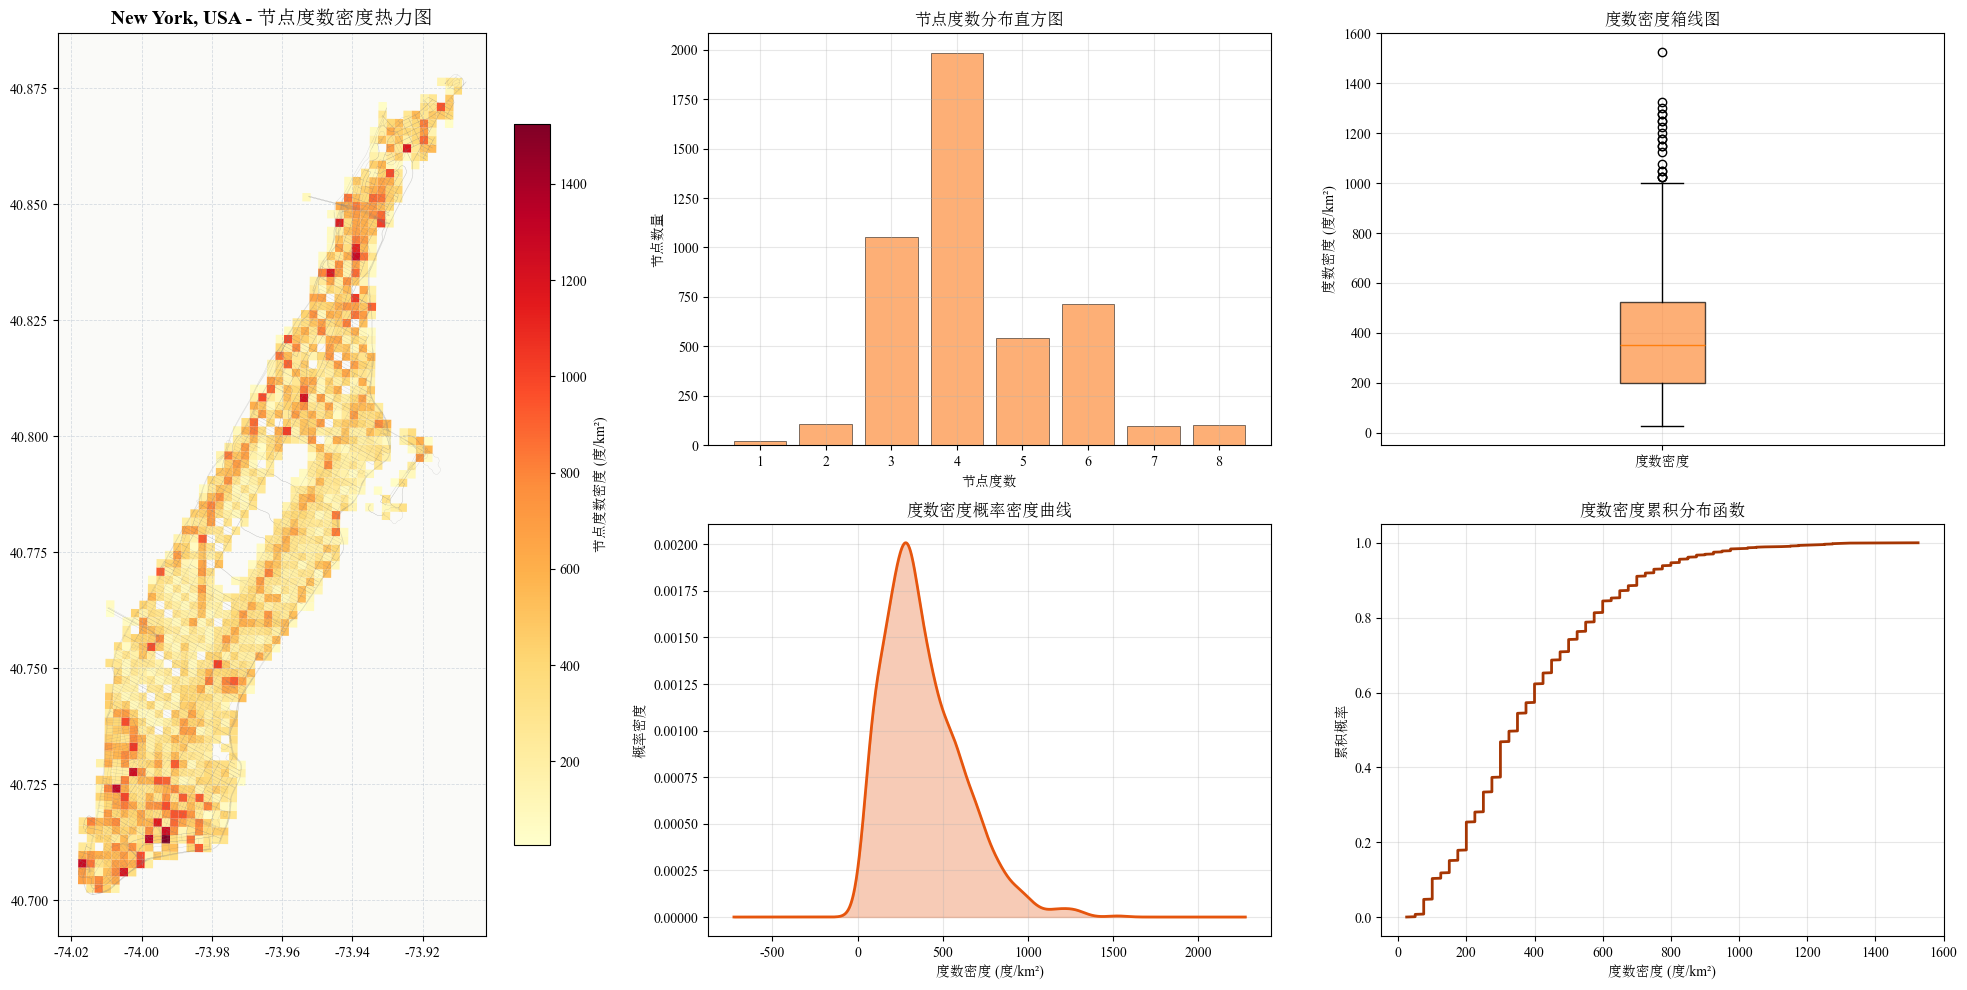


New York, USA - 节点度数连通性详细统计分析
节点总数: 4619
边总数: 9900
总网格数量: 4410
有效网格数量 (度数密度>0): 1274
空网格数量: 3136
空网格比例: 71.1%

节点度数统计:
  最小值: 1
  最大值: 8
  平均值: 4.29
  中位数: 4.0
  标准差: 1.24

度数密度统计 (排除空网格):
  最小值: 25.0 度/km²
  最大值: 1525.0 度/km²
  平均值: 387.8 度/km²
  中位数: 350.0 度/km²
  标准差: 231.9 度/km²
  偏度: 1.036
  峰度: 1.310

度数密度分位数统计:
  10%分位数: 100.0 度/km²
  25%分位数: 200.0 度/km²
  50%分位数: 350.0 度/km²
  75%分位数: 525.0 度/km²
  90%分位数: 700.0 度/km²

度数密度等级分布:
  极低(0-1k): 1253个网格 (98.4%)
  低(1k-2k): 21个网格 (1.6%)
  中(2k-5k): 0个网格 (0.0%)
  高(5k-10k): 0个网格 (0.0%)
  极高(>10k): 0个网格 (0.0%)

节点度数类型统计:
  端点 (度=1): 21个 (0.5%)
  中间点 (度=2): 108个 (2.3%)
  交叉口 (度≥3): 4490个 (97.2%)
格网数据已保存为: New_York_USA_connectivity_grid.geojson
格网数据已保存为: New_York_USA_connectivity_grid.gpkg


In [6]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
from shapely.geometry import Polygon

def analyze_connectivity_degree(G, place_name, grid_size=200):
    """
    基于节点度数分析路网连通性
    """
    # 首先投影到UTM坐标系
    G_proj = ox.project_graph(G)
    nodes, edges = ox.graph_to_gdfs(G_proj)
    
    # 计算每个节点的度数
    node_degrees = dict(G_proj.degree())
    nodes['degree'] = nodes.index.map(node_degrees)
    
    # 计算总度数（每个网格内所有节点度数的总和）
    bounds = nodes.total_bounds
    x_coords = np.arange(bounds[0], bounds[2], grid_size)
    y_coords = np.arange(bounds[1], bounds[3], grid_size)
    
    total_degrees = []
    avg_degrees = []
    grid_polygons = []
    
    for i in range(len(x_coords)-1):
        for j in range(len(y_coords)-1):
            poly = Polygon([
                (x_coords[i], y_coords[j]),
                (x_coords[i+1], y_coords[j]),
                (x_coords[i+1], y_coords[j+1]),
                (x_coords[i], y_coords[j+1])
            ])
            
            # 计算网格内的节点
            nodes_in_grid = nodes[nodes.within(poly)]
            
            if len(nodes_in_grid) > 0:
                # 总度数
                total_degree = nodes_in_grid['degree'].sum()
                # 平均度数（每平方公里的总度数）
                grid_area = grid_size**2 / 1000000  # 平方公里
                avg_degree_density = total_degree / grid_area
            else:
                total_degree = 0
                avg_degree_density = 0
            
            total_degrees.append(total_degree)
            avg_degrees.append(avg_degree_density)
            grid_polygons.append(poly)
    
    # 创建网格GeoDataFrame
    grid_gdf = gpd.GeoDataFrame({
        'total_degree': total_degrees,
        'avg_degree_density': avg_degrees
    }, geometry=grid_polygons, crs=nodes.crs)
    
    # 转换回WGS84用于可视化
    grid_gdf_wgs84 = grid_gdf.to_crs("EPSG:4326")
    nodes_wgs84 = nodes.to_crs("EPSG:4326")
    edges_wgs84 = edges.to_crs("EPSG:4326")
    
    # 过滤掉密度为0的网格用于统计分析
    non_zero_density = grid_gdf[grid_gdf['avg_degree_density'] > 0]['avg_degree_density']
    
    # 创建图形
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(2, 3, figure=fig)
    
    # 左侧：度数密度热力图
    ax1 = fig.add_subplot(gs[:, 0])  # 占据左侧全部
    
    # 使用暖色系色带
    cmap = plt.cm.get_cmap('YlOrRd')
    
    # 绘制热力图（只显示非零区域）
    non_zero_grid = grid_gdf_wgs84[grid_gdf_wgs84['avg_degree_density'] > 0]
    non_zero_grid.plot(column='avg_degree_density', cmap=cmap, ax=ax1, legend=True,
                      legend_kwds={'label': '节点度数密度 (度/km²)', 'shrink': 0.8})
    
    # 添加路网底图
    edges_wgs84.plot(ax=ax1, color='gray', linewidth=0.2, alpha=0.4)
    
    ax1.set_title(f'{place_name} - 节点度数密度热力图', fontsize=14, fontweight='bold')
    # 添加经纬度网格
    ax1.grid(True, alpha=0.4, linestyle='--', color='#A0AEC0', linewidth=0.6)
    ax1.get_xaxis().set_visible(True)
    ax1.get_yaxis().set_visible(True)
    ax1.set_axis_on()
    ax1.set_facecolor('#FAFAF8')
    
    # 右侧：统计图表
    
    # 节点度数分布直方图
    ax2 = fig.add_subplot(gs[0, 1])
    degree_values = list(node_degrees.values())
    degree_counts = pd.Series(degree_values).value_counts().sort_index()
    ax2.bar(degree_counts.index, degree_counts.values, color='#fd8d3c', alpha=0.7, 
            edgecolor='black', linewidth=0.5)
    ax2.set_title('节点度数分布直方图', fontsize=12, fontweight='bold')
    ax2.set_xlabel('节点度数')
    ax2.set_ylabel('节点数量')
    ax2.grid(True, alpha=0.3)
    
    # 度数密度箱线图
    ax3 = fig.add_subplot(gs[0, 2])
    box_data = [non_zero_density.values]
    box_plot = ax3.boxplot(box_data, patch_artist=True, labels=['度数密度'])
    # 设置箱线图颜色（暖色系）
    for patch in box_plot['boxes']:
        patch.set_facecolor('#fd8d3c')
        patch.set_alpha(0.7)
    ax3.set_title('度数密度箱线图', fontsize=12, fontweight='bold')
    ax3.set_ylabel('度数密度 (度/km²)')
    ax3.grid(True, alpha=0.3)
    
    # 度数密度概率密度曲线
    ax4 = fig.add_subplot(gs[1, 1])
    density_curve = non_zero_density.plot.kde(ax=ax4, color='#e6550d', linewidth=2)
    ax4.set_title('度数密度概率密度曲线', fontsize=12, fontweight='bold')
    ax4.set_xlabel('度数密度 (度/km²)')
    ax4.set_ylabel('概率密度')
    ax4.grid(True, alpha=0.3)
    # 填充曲线下方区域
    x = density_curve.lines[0].get_xdata()
    y = density_curve.lines[0].get_ydata()
    ax4.fill_between(x, y, alpha=0.3, color='#e6550d')
    
    # 度数密度累积分布图
    ax5 = fig.add_subplot(gs[1, 2])
    sorted_data = np.sort(non_zero_density)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    ax5.plot(sorted_data, cdf, linewidth=2, color='#a63603')
    ax5.set_title('度数密度累积分布函数', fontsize=12, fontweight='bold')
    ax5.set_xlabel('度数密度 (度/km²)')
    ax5.set_ylabel('累积概率')
    ax5.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # 保存图片
    output_filename = f"connectivity_degree_visualization_{place_name.replace(' ', '_')}.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"可视化结果已保存为: {output_filename}")
    
    plt.show()
    
    # 打印详细统计信息
    print(f"\n{place_name} - 节点度数连通性详细统计分析")
    print("=" * 60)
    print(f"节点总数: {len(nodes)}")
    print(f"边总数: {len(edges)}")
    print(f"总网格数量: {len(grid_gdf)}")
    print(f"有效网格数量 (度数密度>0): {len(non_zero_density)}")
    print(f"空网格数量: {len(grid_gdf) - len(non_zero_density)}")
    print(f"空网格比例: {(len(grid_gdf) - len(non_zero_density)) / len(grid_gdf) * 100:.1f}%")
    
    print("\n节点度数统计:")
    degree_series = pd.Series(degree_values)
    print(f"  最小值: {degree_series.min()}")
    print(f"  最大值: {degree_series.max()}")
    print(f"  平均值: {degree_series.mean():.2f}")
    print(f"  中位数: {degree_series.median()}")
    print(f"  标准差: {degree_series.std():.2f}")
    
    print("\n度数密度统计 (排除空网格):")
    print(f"  最小值: {non_zero_density.min():.1f} 度/km²")
    print(f"  最大值: {non_zero_density.max():.1f} 度/km²")
    print(f"  平均值: {non_zero_density.mean():.1f} 度/km²")
    print(f"  中位数: {non_zero_density.median():.1f} 度/km²")
    print(f"  标准差: {non_zero_density.std():.1f} 度/km²")
    print(f"  偏度: {non_zero_density.skew():.3f}")
    print(f"  峰度: {non_zero_density.kurtosis():.3f}")
    
    # 分位数统计
    print("\n度数密度分位数统计:")
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    for q in quantiles:
        value = non_zero_density.quantile(q)
        print(f"  {int(q*100)}%分位数: {value:.1f} 度/km²")
    
    # 度数密度等级统计
    print("\n度数密度等级分布:")
    density_bins = [0, 1000, 2000, 5000, 10000, float('inf')]
    density_labels = ['极低(0-1k)', '低(1k-2k)', '中(2k-5k)', '高(5k-10k)', '极高(>10k)']
    
    for i in range(len(density_bins)-1):
        if i == len(density_bins)-2:  # 最后一个区间
            count = len(non_zero_density[non_zero_density >= density_bins[i]])
        else:
            count = len(non_zero_density[(non_zero_density >= density_bins[i]) & 
                                       (non_zero_density < density_bins[i+1])])
        percentage = count / len(non_zero_density) * 100
        print(f"  {density_labels[i]}: {count}个网格 ({percentage:.1f}%)")
    
    # 节点度数类型统计
    print("\n节点度数类型统计:")
    degree_1 = len(nodes[nodes['degree'] == 1])
    degree_2 = len(nodes[nodes['degree'] == 2])
    degree_3_plus = len(nodes[nodes['degree'] >= 3])
    
    print(f"  端点 (度=1): {degree_1}个 ({degree_1/len(nodes)*100:.1f}%)")
    print(f"  中间点 (度=2): {degree_2}个 ({degree_2/len(nodes)*100:.1f}%)")
    print(f"  交叉口 (度≥3): {degree_3_plus}个 ({degree_3_plus/len(nodes)*100:.1f}%)")
    
    #储存格网
    base_name = place_name.replace(' ', '_').replace(',', '')
    
    # 保存为GeoJSON
    non_zero_grid_wgs84=non_zero_grid.to_crs("EPSG:4326")
    geojson_file = f"{base_name}_connectivity_grid.geojson"
    non_zero_grid_wgs84.to_file(geojson_file, driver='GeoJSON')
    print(f"格网数据已保存为: {geojson_file}")
    
    # 保存为GPKG
    gpkg_file = f"{base_name}_connectivity_grid.gpkg"
    non_zero_grid_wgs84.to_file(gpkg_file, driver='GPKG')
    print(f"格网数据已保存为: {gpkg_file}")
    
    return grid_gdf_wgs84, nodes

# 使用示例

connectivity_grid, nodes_data = analyze_connectivity_degree(G, "New York, USA")
